### Helper functions

In [1]:
import pandas as pd
from IPython.display import display
import os
import json

os.chdir('..')

In [2]:
!pwd

/Users/alexc/Desktop/UofG/Lvl5-Project/test-suite-enhancement


In [3]:
from src.evaluation_entry import EvaluationEntry


## Helper functions

In [4]:
def get_initial_eval_entry_csv(project_name):
    eval_entries = EvaluationEntry.load_all("initial", project_name)
    data = []

    for eval_entry in eval_entries:
        eval_entry_data = eval_entry.get_eval_entry_csv()
        data.append(eval_entry_data)
    
    init_dfs = pd.concat(data, ignore_index=True)
    # display(init_dfs)
    return init_dfs

In [5]:
def get_enhanced_eval_data(project, settings, optimised_eval=False):
    eval_entries = EvaluationEntry.load_all("enhanced", project)
    data = []
    for eval_entry in eval_entries:
        if "flag" in eval_entry.identifiers and eval_entry.identifiers["flag"] == "old_1":
            continue
        if settings.get('test_source') and eval_entry.get_test_source() != settings['test_source']:
            continue
        if settings.get('test_selection_mode') and eval_entry.identifiers['test_selection_mode'] != settings['test_selection_mode']:
            continue
        if settings.get('num_test_cases') and eval_entry.identifiers['num_test_cases'] != settings['num_test_cases']:
            continue
        if optimised_eval:
            data.append(eval_entry.get_optimised_eval_entry_csv())
        else:
            data.append(eval_entry.get_eval_entry_csv())
    
    enhanced_dfs = pd.concat(data, ignore_index=True)
    return enhanced_dfs

# Example usage
settings = {
    'test_source': "human_written",
    'test_selection_mode': None,
    'num_test_cases': None
}
enhanced_dfs = get_enhanced_eval_data("human_eval", settings)
display(enhanced_dfs)

,eval_id,test_source,num_test_cases,test_selection_mode,total_classes,total_tests,passed,passed_after_repair,syntax_errors,syntax_errors_after_repair,...,cognitive_complexity,cyclomatic_complexity,squale_index,code_smells,bugs,vulnerabilities,syntactically_correct,syntactically_correct_after_repair,compilable,compilable_after_repair
0,0/human_written/random_from_all/1,human_written,1,random_from_all,164,1312,0,1021,0,0,...,7,1023,461,45,34,0,164,164,164,164
1,1/human_written/random_from_all/3,human_written,3,random_from_all,164,1403,8,1139,0,0,...,3,1140,461,45,27,0,164,164,164,164
2,2/human_written/random_from_all/5,human_written,5,random_from_all,164,1499,8,1206,0,0,...,5,1208,632,63,31,0,164,164,164,164
3,3/human_written/random_from_class_under_test/1,human_written,1,random_from_class_under_test,164,1545,7,1173,0,0,...,1,1178,641,60,38,0,164,164,164,164
4,4/human_written/random_from_class_under_test/3,human_written,3,random_from_class_under_test,164,1588,0,1250,0,0,...,2,1252,944,91,31,0,164,164,164,164
5,5/human_written/random_from_class_under_test/5,human_written,5,random_from_class_under_test,164,1602,0,1243,0,0,...,4,1246,744,74,33,0,164,164,164,164
6,6/human_written/problem_similarity/1,human_written,1,problem_similarity,164,1274,0,977,1,0,...,0,977,533,56,33,0,163,164,164,164
7,7/human_written/problem_similarity/3,human_written,3,problem_similarity,164,1468,0,1164,0,0,...,3,1166,358,30,26,0,164,164,164,164
8,8/human_written/problem_similarity/5,human_written,5,problem_similarity,164,1521,6,1235,0,0,...,7,1235,392,33,28,0,164,164,164,164
9,9/human_written/class_similarity_no_definition/1,human_written,1,class_similarity_no_definition,164,1278,0,1004,0,0,...,0,1004,441,52,33,0,164,164,164,164


In [6]:
# Get initial eval entry data
init_dfs = get_initial_eval_entry_csv("human_eval")
display(init_dfs)

,eval_id,test_source,num_test_cases,test_selection_mode,total_classes,total_tests,passed,passed_after_repair,syntax_errors,syntax_errors_after_repair,...,cognitive_complexity,cyclomatic_complexity,squale_index,code_smells,bugs,vulnerabilities,syntactically_correct,syntactically_correct_after_repair,compilable,compilable_after_repair
0,0/pynguin,pynguin,None,None,164,515,211,210,0,0,...,0,211,1106,185,0,0,164,164,164,164
1,1/chatgpt,chatgpt,None,None,164,1170,0,969,0,0,...,0,969,164,25,25,0,164,164,163,164
2,2/human_written,human_written,None,None,164,1181,1172,1172,0,0,...,2,1175,796,103,12,0,164,164,164,164


## Initial number of examples experiment

### Figure code

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_correctness_metrics(df, after_repair=False):
    df = df.copy()
    
    if after_repair:
        df['passed_percentage'] = df['passed_after_repair'] / df['total_tests'] * 100
    else:
        df['passed_percentage'] = df['passed'] / df['total_tests'] * 100
    
    if after_repair:
        df['syntactically_correct_percentage'] = (df['total_classes'] - df['syntax_errors_after_repair']) / df['total_classes'] * 100
    else:
        df['syntactically_correct_percentage'] = (df['total_classes'] - df['syntax_errors']) / df['total_classes'] * 100
    
    if after_repair:
        df['compilable_percentage'] = (df['total_classes'] - df['compilation_errors_after_repair']) / df['total_classes'] * 100
    else:
        df['compilable_percentage'] = (df['total_classes'] - df['compilation_errors']) / df['total_classes'] * 100
    
    # Create a figure with three subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    metrics = ['syntactically_correct_percentage', 'compilable_percentage', 'passed_percentage']
    titles = ['Syntactically Correct Percentage', 'Compilable Percentage', 'Passed Percentage']
    
    for ax, metric, title in zip(axes, metrics, titles):
        # Plot lines for each test source
        sns.lineplot(data=df, x='num_test_cases', y=metric, hue='test_source', 
                     marker='o', ax=ax)
        
        ax.set_title(title)
        ax.set_xlabel('Number of Test Cases')
        ax.set_ylabel('Percentage (%)')
        
        min_val = df[metric].min()
        max_val = df[metric].max()
        padding = (max_val - min_val) * 0.1
        
        y_min = max(0, min_val - padding)
        y_max = min(110, max_val + padding)
        
        if (max_val - min_val) < 5:
            center = (max_val + min_val) / 2
            y_min = max(0, center - 5)
            y_max = min(110, center + 5)
        
        ax.set_ylim(y_min, y_max)
        ax.legend(title='Test Source')
        ax.set_xticks([1, 3, 5])
    
    plt.tight_layout()
    return fig

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_coverage_metrics(df):
    df = df.copy()
    
    # Convert string percentages to float values
    coverage_metrics = ['branch_coverage', 'line_coverage']
    for metric in coverage_metrics:
        df[metric] = df[metric].astype(float)
    
    # Create a figure with three subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    titles = ['Branch Coverage', 'Line Coverage']
    
    for ax, metric, title in zip(axes, coverage_metrics, titles):
        # Plot lines for each test source
        sns.lineplot(data=df, x='num_test_cases', y=metric, hue='test_source', 
                     marker='o', ax=ax)
        
        ax.set_title(title)
        ax.set_xlabel('Number of Test Cases')
        ax.set_ylabel('Percentage (%)')
        
        # Dynamically set y-axis limits with padding
        min_val = df[metric].min()
        max_val = df[metric].max()
        padding = (max_val - min_val) * 0.1
        y_min = max(0, min_val - padding)
        
        if max_val >= 95:
            y_max = min(110, max_val + padding)
        else:
            y_max = min(100, max_val + padding)
        
        if (max_val - min_val) < 5:
            center = (max_val + min_val) / 2
            y_min = max(0, center - 5)
            y_max = min(110 if max_val >= 95 else 100, center + 5)
        
        ax.set_ylim(y_min, y_max)
        
        # Add a light gray line at 100% for reference if we're showing >100%
        if y_max > 100:
            ax.axhline(y=100, color='lightgray', linestyle='--', linewidth=1)
        
        ax.legend(title='Test Source')
        ax.set_xticks([1, 3, 5])
    
    plt.tight_layout()
    return fig


In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_code_quality_metrics(df):
    # Create a copy to avoid modifying the original dataframe
    df = df.copy()
    
    # Define metrics and their display names
    metrics = [
        ('cognitive_complexity', 'Cognitive Complexity'),
        ('cyclomatic_complexity', 'Cyclomatic Complexity'),
        ('squale_index', 'Squale Index'),
        ('code_smells', 'Average No of Code Smells per Test Case'),
        ('lines', 'Average No of Lines of Code per Test Case'),
        ('non_comment_lines', 'Average No of Non-comment Lines per Test Case'),
    ]
    
    # Calculate per-test-case averages where applicable
    if 'total_tests' in df.columns:
        df['code_smells'] = df['code_smells'].astype(float) / df['total_tests'].astype(float)
        df['lines'] = df['lines'].astype(float) / df['total_tests'].astype(float)
        df['non_comment_lines'] = df['non_comment_lines'].astype(float) / df['total_tests'].astype(float)

    for (metric, title) in metrics:
        df[metric] = df[metric].astype(float)

    # Create a figure with subplots (2 rows, 3 columns)
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Flatten axes for easy iteration
    axes = axes.flatten()
    
    for ax, (metric, title) in zip(axes, metrics):
        # Plot lines for each test source
        sns.lineplot(data=df, x='num_test_cases', y=metric, hue='test_source',
                    marker='o', ax=ax)
        
        ax.set_title(title)
        ax.set_xlabel('Number of Example Test Cases')
        ax.set_ylabel(title)
        
        # Dynamically set y-axis limits with padding
        min_val = df[metric].min()
        max_val = df[metric].max()
        padding = (max_val - min_val) * 0.1  # 10% padding
        
        # Use automatic scaling for y-axis limits
        y_min = max(0, min_val - padding)
        y_max = max_val + padding
        
        ax.set_ylim(y_min, y_max)
        
        ax.legend(title='Test Source')
        ax.set_xticks([1, 3, 5])
    
    plt.tight_layout()
    return fig

### Figures

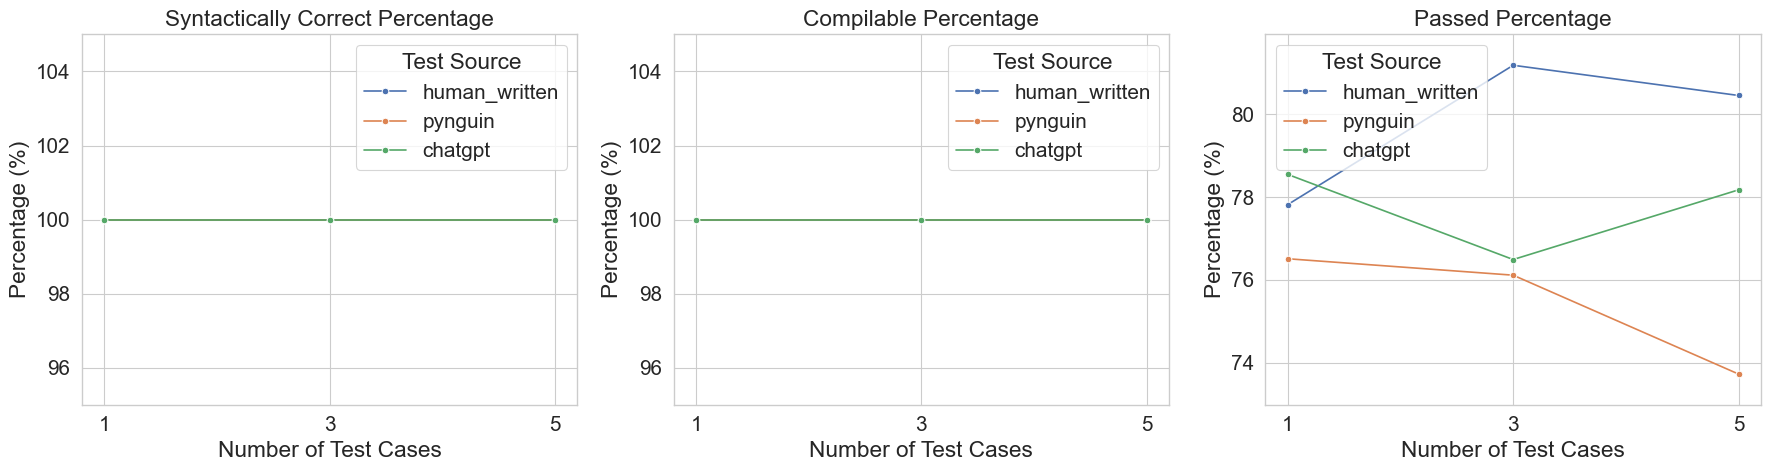

In [48]:
settings = {
    'test_source': None,
    'test_selection_mode': "random_from_all",
    'num_test_cases': None
}
rq0 = get_enhanced_eval_data("human_eval", settings)

fig = plot_correctness_metrics(rq0, after_repair=True)
plt.savefig('data/figures/rq0_correctness_for_no_of_test_examples.png', dpi=300, bbox_inches='tight')
plt.show()

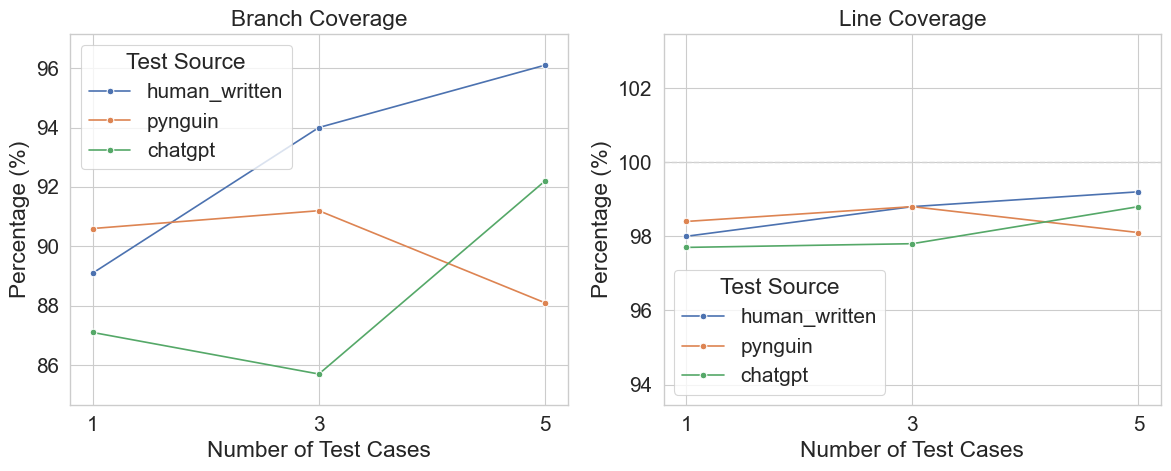

In [49]:
settings = {
    'test_source': None,
    'test_selection_mode': "problem_and_class_similarity",
    'num_test_cases': None
}
enhanced_dfs = get_enhanced_eval_data("human_eval", settings)
# display(enhanced_dfs)

fig = plot_coverage_metrics(rq0)
plt.savefig('data/figures/rq0_coverage_for_no_of_test_examples.png', dpi=300, bbox_inches='tight')
plt.show()

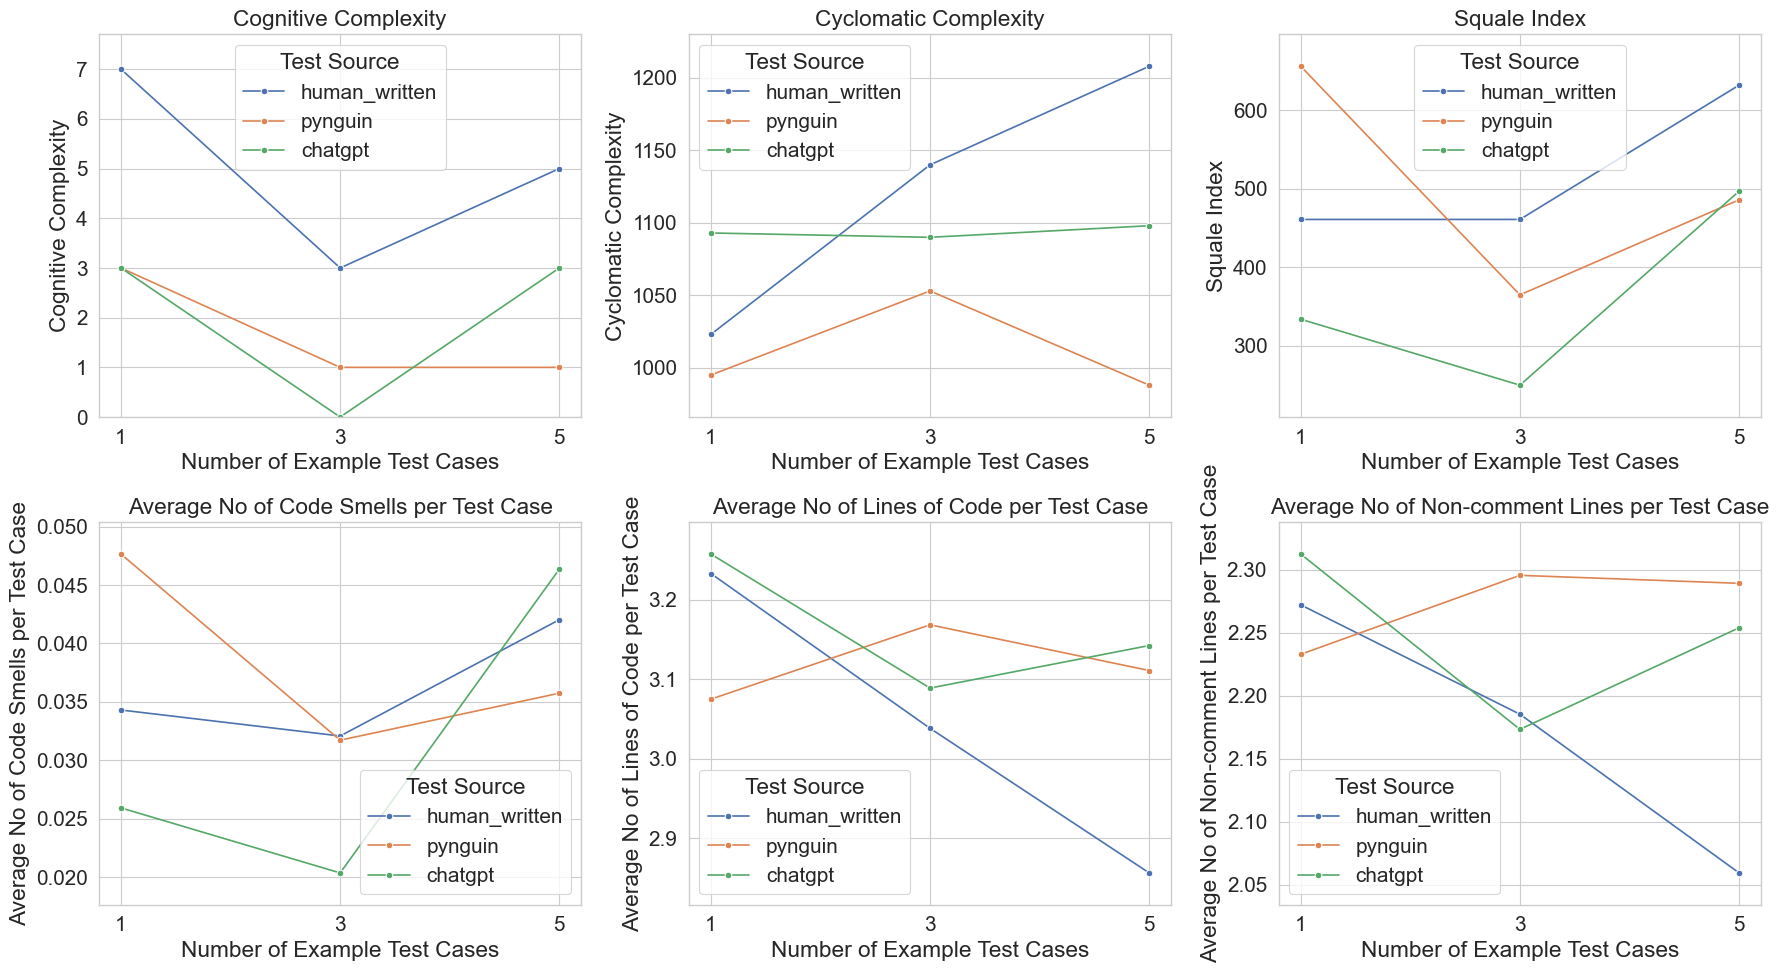

In [50]:
settings = {
    'test_source': None,
    'test_selection_mode': "random_from_all",
    'num_test_cases': None
}
enhanced_dfs = get_enhanced_eval_data("human_eval", settings)
# display(enhanced_dfs)

fig = plot_code_quality_metrics(rq0)
plt.savefig('data/figures/rq0_code_quality_for_no_of_test_examples.png', dpi=300, bbox_inches='tight')
plt.show()

## RQ 1.1: Test correctness

### Figure code

In [13]:
def create_correctness_table(df):
    correctness_cols = [
        'total_tests',
        'total_classes',
        'syntactically_correct',
        'syntactically_correct_after_repair',
        'compilable',
        'compilable_after_repair',
        'passed',
        'passed_after_repair',
        # 'no_test_classes_after_repair'
    ]

    # Create correctness table
    melted = df.melt(
        id_vars=['test_source'],
        value_vars=correctness_cols,
        var_name='metric',
        value_name='value'
    )
    correctness_table = melted.pivot(index='metric', columns='test_source', values='value').fillna(0).astype(int)
    correctness_table = correctness_table.reindex(correctness_cols)
    # Sort the table by the order of correctness_cols
    

    # Create percentage table
    percentage_table = correctness_table.copy().astype(float)

    for col in percentage_table.columns:
        total_tests = percentage_table.loc['total_tests', col]
        total_classes = percentage_table.loc['total_classes', col]
        for idx in percentage_table.index:
            if idx != 'total_tests' and idx != 'total_classes':
                if idx in ['passed', 'passed_after_repair']:
                    total = total_tests
                else:
                    total = total_classes
                percentage_table.loc[idx, col] = (percentage_table.loc[idx, col] / total * 100) if total > 0 else 0.0
            else:
                percentage_table.loc[idx, col] = None  # No % for total_classes

    # Format values
    percentage_table = percentage_table.applymap(
        lambda x: f"{x:.2f}%" if pd.notna(x) else ""
    )
    correctness_table = correctness_table.astype(str)
    percentage_table.index = [f"{i} (%)" if i != 'total_tests' else '' for i in correctness_table.index]

    # Combine both tables
    combined_table = pd.concat([correctness_table, percentage_table])
    combined_table = combined_table[combined_table.index != '']

    # Display
    print(combined_table)

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def create_rule_repair_figure(df:pd.DataFrame):
    repair_cols = [col for col in df.columns if col.endswith('_repair_count') and col.startswith('rule_') and col != 'rule_0_repair_count']

    melted_df = df.melt(
        id_vars=['test_source', 'total_classes'],
        value_vars=repair_cols,
        var_name='rule',
        value_name='repair_count'
    )
    # Calculate percentage of classes that underwent each repair rule
    melted_df['pct_classes_repaired'] = (melted_df['repair_count'] / melted_df['total_classes']) * 100

    melted_df['rule'] = melted_df['rule'].str.replace('_repair_count', '').str.replace('rule_', 'Rule ')

    plt.figure(figsize=(10, 5))
    sns.set_theme(style="whitegrid")
    sns.set_context("paper", font_scale=1.7)

    sns.barplot(data=melted_df, x='rule', y='pct_classes_repaired', hue='test_source')

    # plt.yscale('log') # Use log scale to better visualize the differences

    # Adjust layout
    plt.tight_layout()

    plt.ylabel('% of Classes Repaired')
    plt.xlabel('Repair Rule')
    plt.legend(title='Test Source', fontsize=13, title_fontsize=14, loc='upper right', frameon=True, framealpha=0.9)
    plt.tight_layout()
    plt.savefig('data/figures/rq1_1_repair_rule_pct.png', dpi=300, bbox_inches='tight')
    plt.show()

### Figures

In [129]:
settings = {
    'test_source': None,
    'test_selection_mode': "random_from_class_under_test",
    'num_test_cases': 5
}
print("ENHANCED DATA")
used_settings = { k:v for k,v in settings.items() if v is not None }
for setting in used_settings:
    print(f"{setting}: {used_settings[setting]}")
rq1_1_dfs = get_enhanced_eval_data("human_eval", settings)
display(rq1_1_dfs)
create_correctness_table(rq1_1_dfs)

ENHANCED DATA
test_selection_mode: random_from_class_under_test
num_test_cases: 5


,eval_id,test_source,num_test_cases,test_selection_mode,total_classes,total_tests,passed,passed_after_repair,syntax_errors,syntax_errors_after_repair,...,cognitive_complexity,cyclomatic_complexity,squale_index,code_smells,bugs,vulnerabilities,syntactically_correct,syntactically_correct_after_repair,compilable,compilable_after_repair
0,5/human_written/random_from_class_under_test/5,human_written,5,random_from_class_under_test,164,1602,0,1243,0,0,...,4,1246,744,74,33,0,164,164,164,164
1,23/pynguin/random_from_class_under_test/5,pynguin,5,random_from_class_under_test,164,1655,338,1158,0,0,...,5,1128,821,75,32,0,164,164,144,164
2,41/chatgpt/random_from_class_under_test/5,chatgpt,5,random_from_class_under_test,164,980,0,680,2,0,...,4,684,223,30,28,0,162,164,164,164


test_source                             chatgpt human_written  pynguin
total_tests                                 980          1602     1655
total_classes                               164           164      164
syntactically_correct                       162           164      164
syntactically_correct_after_repair          164           164      164
compilable                                  164           164      144
compilable_after_repair                     164           164      164
passed                                        0             0      338
passed_after_repair                         680          1243     1158
total_classes (%)                                                     
syntactically_correct (%)                98.78%       100.00%  100.00%
syntactically_correct_after_repair (%)  100.00%       100.00%  100.00%
compilable (%)                          100.00%       100.00%   87.80%
compilable_after_repair (%)             100.00%       100.00%  100.00%
passed

/var/folders/z7/grqfp40j73xcvr_rkz8n20hm0000gn/T/ipykernel_38951/2442684477.py:43: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  percentage_table = percentage_table.applymap(


REPAIR RULE 


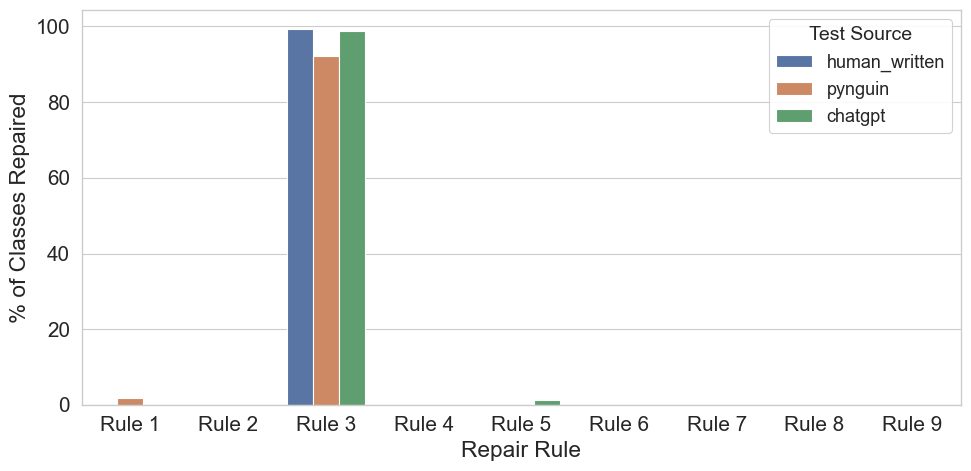

In [52]:
# Display the repair count figure
print("REPAIR RULE ")
create_rule_repair_figure(rq1_1_dfs)

## RQ 1.2: Coverage metrics

### Figure code

In [53]:
# Coverage metrics

def create_coverage_table(df, settings=None):
    coverage_cols = [
        # "coverage",
        "branch_coverage",
        "line_coverage",
        # "lines_to_cover",
        # "uncovered_lines"
    ]
    
    # Make the value which is None as id_var
    if settings is not None:
        id_var = next((k for k, v in settings.items() if v is None), None)
    else:
        id_var = 'test_source'
        settings = 'initial'
    
    # Create correctness table
    melted = df.melt(
        id_vars=[id_var],
        value_vars=coverage_cols,
        var_name='metric',
        value_name='value'
    )
    coverage_table = melted.pivot(index='metric', columns=id_var, values='value').fillna(0)
    coverage_table = coverage_table.reindex(coverage_cols)
    # Sort the table by the order of coverage_cols

    # Format values
    coverage_table = coverage_table.astype(str) + "%"

    # Display
    print(f"INFO: {settings}")
    print(coverage_table)

### Figures

In [54]:
settings = {
    'test_source': None,
    'test_selection_mode': "random_from_all",
    'num_test_cases': 3
}
rq1_2_dfs = get_enhanced_eval_data("human_eval", settings)
create_coverage_table(rq1_2_dfs, settings=settings)

INFO: {'test_source': None, 'test_selection_mode': 'random_from_all', 'num_test_cases': 3}
test_source     chatgpt human_written pynguin
metric                                       
branch_coverage   85.7%         94.0%   91.2%
line_coverage     97.8%         98.8%   98.8%


## RQ 1.3: Code quality

### Figure code

In [59]:
# Code quality metrics

def create_code_quality_table(df, settings=None):
    code_quality_cols = [
        "cyclomatic_complexity",
        "cognitive_complexity",
        "squale_index",
        "code_smells",
        # "bugs",
        # "vulnerabilities"
        # "lines",
        "non_comment_lines",
        # "comment_lines",
    ]
    df = df.copy()

    if 'total_tests' in df.columns:
        df['squale_index'] = round(df['squale_index'].astype(float) / df['total_tests'].astype(float), 2)
        df['code_smells'] = round(df['code_smells'].astype(float) / df['total_tests'].astype(float), 2)
        df['non_comment_lines'] = round(df['non_comment_lines'].astype(float) / df['total_tests'].astype(float), 2)

    # Make the value which is None as id_var
    if settings is not None:
        id_var = next((k for k, v in settings.items() if v is None), None)
    else:
        id_var = 'test_source'
        settings = 'initial'
    
    # Create correctness table
    melted = df.melt(
        id_vars=[id_var],
        value_vars=code_quality_cols,
        var_name='metric',
        value_name='value'
    )
    code_quality_table = melted.pivot(index='metric', columns=id_var, values='value').fillna(0)
    code_quality_table = code_quality_table.reindex(code_quality_cols)
    # Sort the table by the order of coverage_cols

    # Format values
    code_quality_table = code_quality_table.astype(str)

    # Display
    print(f"INFO: {settings}")
    print(code_quality_table)

### Figures

In [60]:
settings = {
    'test_source': None,
    'test_selection_mode': "random_from_all",
    'num_test_cases': 3
}
rq1_3_dfs = get_enhanced_eval_data("human_eval", settings)
create_code_quality_table(rq1_3_dfs, settings)

INFO: {'test_source': None, 'test_selection_mode': 'random_from_all', 'num_test_cases': 3}
test_source           chatgpt human_written pynguin
metric                                             
cyclomatic_complexity    1090          1140    1053
cognitive_complexity        0             3       1
squale_index             0.18          0.33    0.25
code_smells              0.02          0.03    0.03
non_comment_lines        2.17          2.19     2.3


## RQ 1.4: Test suite optimisation statistics

### Figure code

In [21]:
# Create a table showing the total test numbers

def create_optimisation_test_count_table(df, settings=None, show_percentages=False):
    optimisation_test_count_cols = [
        "total_tests",
        "total_kept_tests",
        "total_removed_tests",
        "total_skipped_tests",
        # "total_faulty_tests"
    ]

    display_names = {
        "total_tests": "Total Tests",
        "total_kept_tests": "Kept Tests",
        "total_removed_tests": "Removed Tests",
        "total_skipped_tests": "Skipped Tests",
        # "total_faulty_tests": "Faulty Tests"
    }
    
    if settings is not None:
        id_var = next((k for k, v in settings.items() if v is None), None)
    else:
        id_var = 'test_source'
    
    # Create correctness table
    melted = df.melt(
        id_vars=[id_var],
        value_vars=optimisation_test_count_cols,
        var_name='metric',
        value_name='value'
    )
    if show_percentages:
        melted['value'] = melted['value'].astype(float)

    optimisation_test_count_table = melted.pivot(index='metric', columns=id_var, values='value').fillna(0)
    optimisation_test_count_table = optimisation_test_count_table.reindex(optimisation_test_count_cols) # Sort the table by the order of optimisation_test_count_cols
    
    if show_percentages:
        optimisation_test_count_table = optimisation_test_count_table.astype(float)
        # Calculate percentages for all metrics except total_tests
        total_tests = optimisation_test_count_table.loc["total_tests"]
        for metric in optimisation_test_count_cols[1:]:  # Skip total_tests
            optimisation_test_count_table.loc[metric] = (optimisation_test_count_table.loc[metric] / total_tests) * 100
        
        optimisation_test_count_table = optimisation_test_count_table.round(2)
        optimisation_test_count_table = optimisation_test_count_table.astype(str) + "%"
        
        optimisation_test_count_table = optimisation_test_count_table.drop("total_tests")
    else:
        optimisation_test_count_table = optimisation_test_count_table.astype(str)

    optimisation_test_count_table = optimisation_test_count_table.rename(index=display_names)

    # Display
    print(f"INFO: {settings}")
    print(optimisation_test_count_table)

In [102]:
def create_optimisation_coverage_improvement_table(optimised_df, initial_df):
    # Define the test sources and metrics
    test_sources = ["human_written", "pynguin", "chatgpt"]
    metrics = {
        "branch_coverage": "Branch Coverage",
        "line_coverage": "Line Coverage"
    }
    
    # Initialize the result dictionary
    result_data = []
    
    for metric_col, metric_name in metrics.items():
        # Add initial values row
        initial_row = {"Metric": f"{metric_name} (Initial)"}
        optimized_row = {"Metric": f"{metric_name} (Optimized)"}
        diff_row = {"Metric": f"{metric_name} (Δ)"}
        
        for source in test_sources:
            # Get initial and optimized values
            init_val = float(initial_df[initial_df["test_source"] == source][metric_col].values[0])
            opt_val = float(optimised_df[optimised_df["test_source"] == source][metric_col].values[0])
            
            # Calculate difference
            difference = opt_val - init_val
            
            # Format values
            initial_row[source] = f"{init_val:.1f}%"
            optimized_row[source] = f"{opt_val:.1f}%"
            diff_row[source] = f"{difference:+.1f}%"
        
        # Add rows to results
        result_data.extend([initial_row, optimized_row, diff_row])
    
    # Create DataFrame and set index
    result_df = pd.DataFrame(result_data)
    result_df.set_index("Metric", inplace=True)
    
    return result_df

In [107]:
def create_optimisation_code_quality_improvement_table(optimised_df, initial_df):
    # Define the test sources and metrics
    test_sources = ["human_written", "pynguin", "chatgpt"]
    metrics = {
        "cyclomatic_complexity" : "Cyclomatic Complexity",
        "cognitive_complexity": "Cognitive Complexity",
        "squale_index_avg": "Avg Technical Debt",
        "code_smells_avg": "Avg Code Smells",
        "non_comment_lines_avg": "Avg Non-comment Lines",
    }
    
    # Calculate average values
    for avg_metric in ["squale_index", "code_smells", "non_comment_lines"]:
        optimised_df[avg_metric+"_avg"] = optimised_df[avg_metric].astype(float) / optimised_df["total_tests"].astype(float)
        initial_df[avg_metric+"_avg"] = initial_df[avg_metric].astype(float) / initial_df["total_tests"].astype(float)

    # Initialize the result dictionary
    result_data = []
    
    for metric_col, metric_name in metrics.items():
        # Add initial values row
        initial_row = {"Metric": f"{metric_name} (Initial)"}
        optimized_row = {"Metric": f"{metric_name} (Optimized)"}
        diff_row = {"Metric": f"{metric_name} (Δ)"}
        
        for source in test_sources:
            # Get initial and optimized values
            init_val = float(initial_df[initial_df["test_source"] == source][metric_col].values[0])
            opt_val = float(optimised_df[optimised_df["test_source"] == source][metric_col].values[0])
            
            # Calculate difference
            difference = opt_val - init_val
            
            # Format values
            if metric_col in ["squale_index_avg", "code_smells_avg", "non_comment_lines_avg"]:
                initial_row[source] = f"{init_val:.2f}"
                optimized_row[source] = f"{opt_val:.2f}"
                diff_row[source] = f"{difference:+.2f}"
            else: 
                initial_row[source] = f"{init_val:.0f}"
                optimized_row[source] = f"{opt_val:.0f}"
                diff_row[source] = f"{difference:+.0f}"
        
        # Add rows to results
        result_data.extend([initial_row, optimized_row, diff_row])
    
    # Create DataFrame and set index
    result_df = pd.DataFrame(result_data)
    result_df.set_index("Metric", inplace=True)
    
    return result_df

### Figures

In [130]:
settings = {
    'test_source': None,
    'test_selection_mode': "random_from_class_under_test",
    'num_test_cases': 5
}
optimised_dfs = get_enhanced_eval_data("human_eval", settings, optimised_eval=True)
display(optimised_dfs)

initial_dfs = get_initial_eval_entry_csv("human_eval")
display(initial_dfs)

,eval_id,test_source,num_test_cases,test_selection_mode,total_classes,total_tests,total_kept_tests,total_removed_tests,total_skipped_tests,total_faulty_tests,...,execution_time,lines,non_comment_lines,comment_lines,cognitive_complexity,cyclomatic_complexity,squale_index,code_smells,bugs,vulnerabilities
0,5/human_written/random_from_class_under_test/5,human_written,5,random_from_class_under_test,164,1282,19,71,1192,0,...,5.31,4761,2750,93,2,1194,802,104,13,0
1,23/pynguin/random_from_class_under_test/5,pynguin,5,random_from_class_under_test,164,1808,114,123,1527,44,...,3.20,3063,1920,384,0,325,1151,191,7,0
2,41/chatgpt/random_from_class_under_test/5,chatgpt,5,random_from_class_under_test,164,1094,15,35,1044,0,...,4.44,3951,2793,54,0,984,164,25,27,0


,eval_id,test_source,num_test_cases,test_selection_mode,total_classes,total_tests,passed,passed_after_repair,syntax_errors,syntax_errors_after_repair,...,cognitive_complexity,cyclomatic_complexity,squale_index,code_smells,bugs,vulnerabilities,syntactically_correct,syntactically_correct_after_repair,compilable,compilable_after_repair
0,0/pynguin,pynguin,None,None,164,515,211,210,0,0,...,0,211,1106,185,0,0,164,164,164,164
1,1/chatgpt,chatgpt,None,None,164,1170,0,969,0,0,...,0,969,164,25,25,0,164,164,163,164
2,2/human_written,human_written,None,None,164,1181,1172,1172,0,0,...,2,1175,796,103,12,0,164,164,164,164


In [131]:
data = optimised_dfs.copy()
# display(data)
create_optimisation_test_count_table(data, settings=settings)

# TODO: find the reason why the total test count is not matching the values from previous table

INFO: {'test_source': None, 'test_selection_mode': 'random_from_class_under_test', 'num_test_cases': 5}
test_source   chatgpt human_written pynguin
metric                                     
Total Tests      1094          1282    1808
Kept Tests         15            19     114
Removed Tests      35            71     123
Skipped Tests    1044          1192    1527


In [125]:
data = optimised_dfs.copy()
# display(data)
create_optimisation_test_count_table(data, settings=settings, show_percentages=True)

INFO: {'test_source': None, 'test_selection_mode': 'random_from_all', 'num_test_cases': 3}
test_source   chatgpt human_written pynguin
metric                                     
Kept Tests      0.97%          1.2%   8.78%
Removed Tests   6.61%         5.48%   7.85%
Skipped Tests  92.37%        93.32%  81.27%


In [126]:
# Compare the initial and optimised coverage metrics
create_optimisation_coverage_improvement_table(optimised_dfs, initial_dfs)

,human_written,pynguin,chatgpt
Metric,,,
Branch Coverage (Initial),95.5%,64.5%,92.8%
Branch Coverage (Optimized),97.2%,95.4%,98.0%
Branch Coverage (Δ),+1.7%,+30.9%,+5.2%
Line Coverage (Initial),99.0%,89.0%,98.6%
Line Coverage (Optimized),99.5%,98.4%,99.7%
Line Coverage (Δ),+0.5%,+9.4%,+1.1%


In [ ]:
create_optimisation_code_quality_improvement_table(optimised_dfs, initial_dfs)

,human_written,pynguin,chatgpt
Metric,,,
Cyclomatic Complexity (Initial),1175,211,969
Cyclomatic Complexity (Optimized),1189,324,987
Cyclomatic Complexity (Δ),+14,+113,+18
Cognitive Complexity (Initial),2,0,0
Cognitive Complexity (Optimized),2,0,0
Cognitive Complexity (Δ),+0,+0,+0
Avg Technical Debt (Initial),0.67,2.15,0.14
Avg Technical Debt (Optimized),0.68,0.87,0.09
Avg Technical Debt (Δ),+0.01,-1.27,-0.05


## RQ 2.1: Selection technique test correctness

### Figure code

In [119]:
def create_correctness_table_selection_techniques(df):
    correctness_cols = [
        'total_tests',
        'total_classes',
        'syntactically_correct',
        'syntactically_correct_after_repair',
        'compilable',
        'compilable_after_repair',
        'passed',
        'passed_after_repair',
        # 'no_test_classes_after_repair'
    ]

    # Create correctness table
    melted = df.melt(
        id_vars=['test_source'],
        value_vars=correctness_cols,
        var_name='metric',
        value_name='value'
    )
    correctness_table = melted.pivot(index='metric', columns='test_source', values='value').fillna(0).astype(int)
    correctness_table = correctness_table.reindex(correctness_cols)
    # Sort the table by the order of correctness_cols
    

    # Create percentage table
    percentage_table = correctness_table.copy().astype(float)

    for col in percentage_table.columns:
        total_tests = percentage_table.loc['total_tests', col]
        total_classes = percentage_table.loc['total_classes', col]
        for idx in percentage_table.index:
            if idx != 'total_tests' and idx != 'total_classes':
                if idx in ['passed', 'passed_after_repair']:
                    total = total_tests
                else:
                    total = total_classes
                percentage_table.loc[idx, col] = (percentage_table.loc[idx, col] / total * 100) if total > 0 else 0.0
            else:
                percentage_table.loc[idx, col] = None  # No % for total_classes

    # Format values
    percentage_table = percentage_table.applymap(
        lambda x: f"{x:.2f}%" if pd.notna(x) else ""
    )
    correctness_table = correctness_table.astype(str)
    percentage_table.index = [f"{i} (%)" if i != 'total_tests' else '' for i in correctness_table.index]

    # Combine both tables
    combined_table = pd.concat([correctness_table, percentage_table])
    combined_table = combined_table[combined_table.index != '']

    # Display
    print(combined_table)

In [120]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def create_rule_repair_figure_selection_techniques(df:pd.DataFrame):
    repair_cols = [col for col in df.columns if col.endswith('_repair_count') and col.startswith('rule_') and col != 'rule_0_repair_count']

    melted_df = df.melt(
        id_vars=['test_source', 'total_classes'],
        value_vars=repair_cols,
        var_name='rule',
        value_name='repair_count'
    )
    # Calculate percentage of classes that underwent each repair rule
    melted_df['pct_classes_repaired'] = (melted_df['repair_count'] / melted_df['total_classes']) * 100

    melted_df['rule'] = melted_df['rule'].str.replace('_repair_count', '').str.replace('rule_', 'Rule ')

    plt.figure(figsize=(10, 5))
    sns.set_theme(style="whitegrid")
    sns.set_context("paper", font_scale=1.7)

    sns.barplot(data=melted_df, x='rule', y='pct_classes_repaired', hue='test_source')

    # plt.yscale('log') # Use log scale to better visualize the differences

    # Adjust layout
    plt.tight_layout()

    plt.ylabel('% of Classes Repaired')
    plt.xlabel('Repair Rule')
    plt.legend(title='Test Source', fontsize=13, title_fontsize=14, loc='upper right', frameon=True, framealpha=0.9)
    plt.tight_layout()
    plt.savefig('data/figures/rq1_1_repair_rule_pct.png', dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
# Chart

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def create_code_coverage_chart(df, settings=None, display_variable="coverage"):
    # Validate input
    if settings is None:
        settings = {'test_source': None, 'test_selection_mode': None, 'num_test_cases': 1}
    
    # Identify varying and fixed variables
    varying_vars = [k for k, v in settings.items() if v is None]
    fixed_vars = {k: v for k, v in settings.items() if v is not None}
    fixed_var = next((k for k, v in settings.items() if v is not None), None)
    
    if len(varying_vars) != 2:
        raise ValueError("Exactly 2 variables must vary (be set to `None`).")

    # Filter data based on fixed settings
    mask = pd.Series(True, index=df.index)
    for key, val in fixed_vars.items():
        mask &= (df[key] == val)
    df_filtered = df[mask]

    # Ensure display_variable exists in the DataFrame
    if display_variable not in df_filtered.columns:
        raise ValueError(f"Column {display_variable} not found in the DataFrame.")
    
    # Convert display_variable to numeric, coercing errors (e.g., strings) to NaN
    df_filtered[display_variable] = pd.to_numeric(
        df_filtered[display_variable],
        errors='coerce'  # Convert non-numeric to NaN
    )
    
    # Drop rows where 'coverage' is NaN (if any conversion failed)
    df_filtered = df_filtered.dropna(subset=[display_variable]) 

    # Pivot data for plotting
    pivot_df = df_filtered.pivot(
        index=varying_vars[0],
        columns=varying_vars[1],
        values=display_variable
    ).fillna(0)

    # Plotting
    label = display_variable.replace("_", " ").capitalize()
    plt.figure(figsize=(12, 6))
    sns.heatmap(pivot_df, annot=True, fmt=".2f", cmap="Blues", cbar_kws={'label': label})
    plt.title(f"{label} for  {fixed_var.replace('_', ' ').capitalize()} = {fixed_vars[fixed_var]}")
    plt.xlabel(varying_vars[1])
    plt.ylabel(varying_vars[0])
    plt.show()

### Figures

In [117]:
settings = {
    'test_source': None,
    'test_selection_mode': None,
    'num_test_cases': 3  # Vary two variables
}
rq2_1_data = get_enhanced_eval_data("human_eval", settings)
display(rq2_1_data)

,eval_id,test_source,num_test_cases,test_selection_mode,total_classes,total_tests,passed,passed_after_repair,syntax_errors,syntax_errors_after_repair,...,cognitive_complexity,cyclomatic_complexity,squale_index,code_smells,bugs,vulnerabilities,syntactically_correct,syntactically_correct_after_repair,compilable,compilable_after_repair
0,1/human_written/random_from_all/3,human_written,3,random_from_all,164,1403,8,1139,0,0,...,3,1140,461,45,27,0,164,164,164,164
1,4/human_written/random_from_class_under_test/3,human_written,3,random_from_class_under_test,164,1588,0,1250,0,0,...,2,1252,944,91,31,0,164,164,164,164
2,7/human_written/problem_similarity/3,human_written,3,problem_similarity,164,1468,0,1164,0,0,...,3,1166,358,30,26,0,164,164,164,164
3,10/human_written/class_similarity_no_definition/3,human_written,3,class_similarity_no_definition,164,1480,0,1192,1,0,...,2,1192,465,55,26,0,163,164,164,164
4,13/human_written/class_similarity_with_definit...,human_written,3,class_similarity_with_definition,164,1488,8,1171,0,0,...,3,1173,397,32,28,0,164,164,164,164
5,16/human_written/problem_and_class_similarity/3,human_written,3,problem_and_class_similarity,164,1471,5,1168,0,0,...,3,1170,317,36,33,0,164,164,164,164
6,19/pynguin/random_from_all/3,pynguin,3,random_from_all,164,1482,90,1128,0,0,...,1,1053,365,47,29,0,164,164,164,164
7,22/pynguin/random_from_class_under_test/3,pynguin,3,random_from_class_under_test,164,1679,268,1202,0,0,...,8,1141,643,70,36,0,164,164,148,164
8,25/pynguin/problem_similarity/3,pynguin,3,problem_similarity,164,1487,87,1086,0,0,...,4,921,412,40,30,0,164,164,162,164
9,28/pynguin/class_similarity_no_definition/3,pynguin,3,class_similarity_no_definition,164,1510,118,1122,0,0,...,5,979,340,47,29,0,164,164,161,164


In [ ]:
create_correctness_table_selection_techniques(rq2_1_data)

In [ ]:
create_rule_repair_figure_selection_techniques(rq2_1_data)

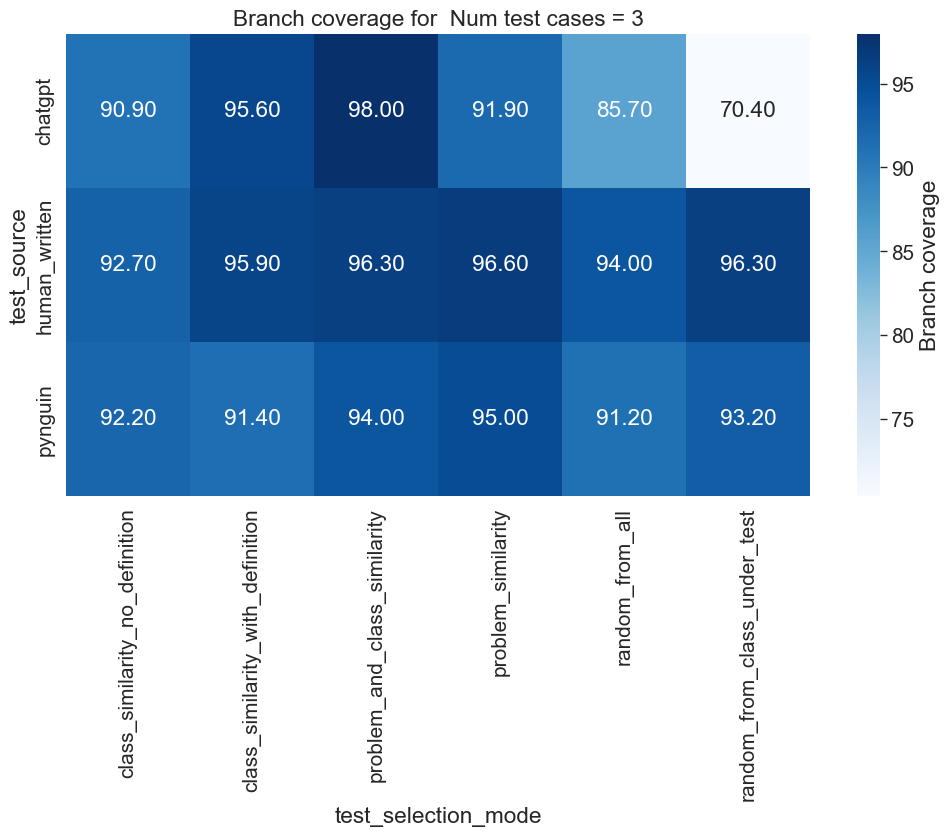

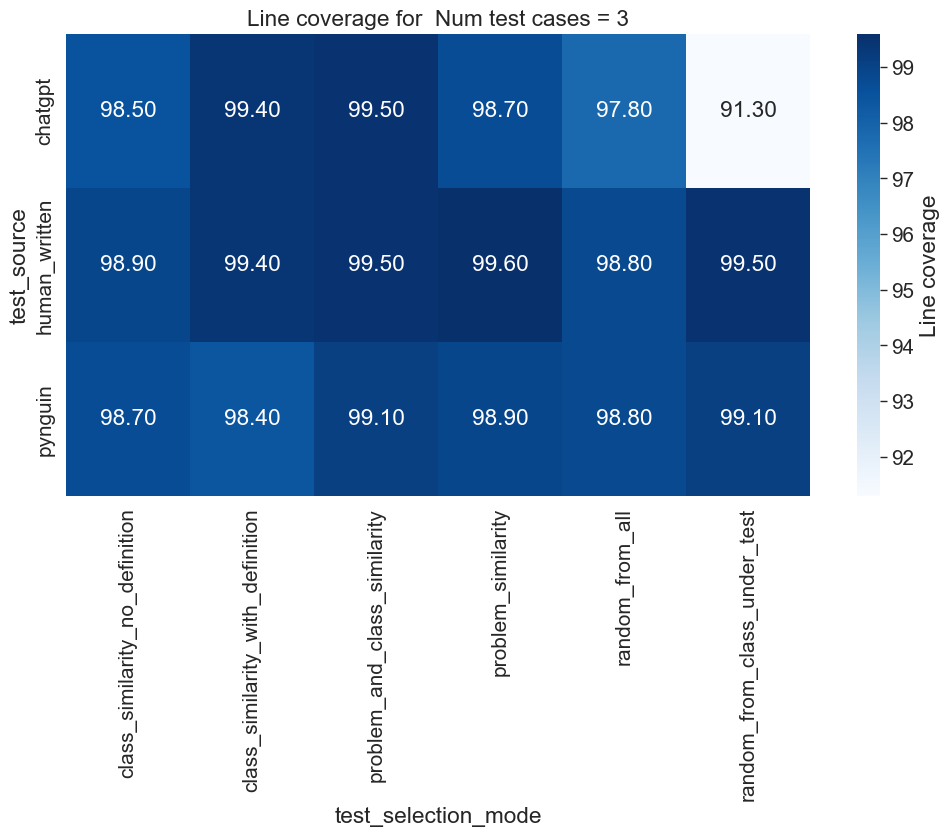

In [118]:
create_code_coverage_chart(rq2_1_data, settings=settings, display_variable="branch_coverage")
create_code_coverage_chart(rq2_1_data, settings, "line_coverage")